In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd;
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
raw_data = pd.read_csv('Datasets/creditcard.csv')
raw_data

NameError: ignored

In [ ]:
raw_data = raw_data.drop("Time",axis=1)



In [ ]:
raw_data.Class.unique()
features = raw_data.drop("Class",axis=1)



In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features,raw_data['Class'],random_state=4,test_size=0.3)

In [ ]:
train_data = x_train.loc[y_train[y_train==1].index]

In [ ]:
minmax = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = minmax.fit_transform(train_data)
x_test_scaled = minmax.transform(x_test)

In [ ]:
class AutoEncoder(Model):
    def __init__(self,output_unit,ldim=8):
        super().__init__()
        self.encoder = Sequential([
#             Dense(64,activation='relu'),
#             Dropout(0.1),
#             Dense(32,activation='relu'),
#             Dropout(0.1),
            Dense(16,activation='relu'),
            Dropout(0.1),
            Dense(ldim,activation='relu')
        ])
        self.decoder = Sequential([
            Dense(16,activation='relu'),
#             Dropout(0.1),
#             Dense(32,activation='relu'),
#             Dropout(0.1),
#             Dense(64,activation='relu'),
            Dropout(0.1),
            Dense(output_unit,activation='sigmoid')
        ])
    def call(self,inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded



In [ ]:
model = AutoEncoder(output_unit =  x_train_scaled.shape[1])
model.compile(optimizer='adam',loss='msle',metrics=['mse'])
h = model.fit(
    x_train_scaled,
    x_train_scaled,
    validation_data=(x_test_scaled,x_test_scaled),epochs=20,batch_size=512
)
print(x_train_scaled.shape[1])



Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0321 - mse: 0.0711 - val_loss: 0.0446 - val_mse: 0.1037
Epoch 2/20
1/1 [==============================] - 0s 334ms/step - loss: 0.0316 - mse: 0.0699 - val_loss: 0.0439 - val_mse: 0.1021
Epoch 3/20
1/1 [==============================] - 0s 279ms/step - loss: 0.0311 - mse: 0.0687 - val_loss: 0.0432 - val_mse: 0.1005
Epoch 4/20
1/1 [==============================] - 0s 336ms/step - loss: 0.0304 - mse: 0.0673 - val_loss: 0.0425 - val_mse: 0.0990
Epoch 5/20
1/1 [==============================] - 0s 337ms/step - loss: 0.0297 - mse: 0.0657 - val_loss: 0.0419 - val_mse: 0.0976
Epoch 6/20
1/1 [==============================] - 0s 337ms/step - loss: 0.0296 - mse: 0.0655 - val_loss: 0.0413 - val_mse: 0.0963
Epoch 7/20
1/1 [==============================] - 0s 271ms/step - loss: 0.0292 - mse: 0.0645 - val_loss: 0.0408 - val_mse: 0.0950
Epoch 8/20
1/1 [==============================] - 0s 284ms/step - loss: 0.0287 - mse: 0.0635 

In [ ]:
import matplotlib.pyplot as plt

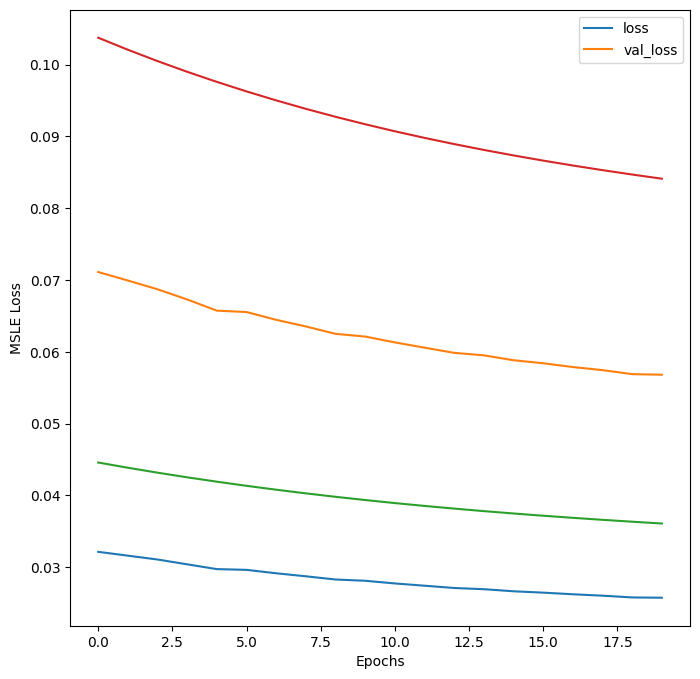

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['mse'])
plt.plot(h.history['val_loss'])
plt.plot(h.history['val_mse'])
plt.legend(['loss','val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.show()



In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd



In [ ]:
def find_threshold(model,x_train_scaled):
    recons = model.predict(x_train_scaled)
    recons_error = tf.keras.metrics.msle(recons,x_train_scaled)
    threshold = np.mean(recons_error.numpy()) + np.std(recons_error.numpy())
    return threshold

In [ ]:
def get_pred(model,x_test_scaled,threshold):
    pred = model.predict(x_test_scaled)
    error = tf.keras.metrics.msle(pred,x_test_scaled)
    AnomalyMask = pd.Series(error)>threshold
    return AnomalyMask.map(lambda x:0.0 if x==True else 1.0)

In [ ]:
threshold = find_threshold(model,x_train_scaled)
print(threshold)

11/11 [==============================] - 0s 2ms/step
0.03333936521504564


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
pred = get_pred(model,x_test_scaled,threshold)

2671/2671 [==============================] - 4s 1ms/step


In [ ]:
accuracy_score(pred,y_test)

0.8598363821495032